In [ ]:
!pip install --upgrade datasets

In [2]:
exit()

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.io import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import to_tensor

import warnings
warnings.simplefilter('ignore')

In [ ]:
from huggingface_hub import login
from datasets import load_dataset
login('')

In [ ]:
train = load_dataset("aanosov/cv_lab1_images001", use_auth_token=True)
train = train.rename_column("color", "label")
train = train.remove_columns(['brand', 'model', 'year'])
train

In [4]:
colors = set(train['train']['label'])
n_colors = len(colors)

color_index_map = {l: i for i, l in enumerate(colors)}
index_color_map = {i: l for l, i in color_index_map.items()}


In [5]:
index_color_map

{0: 'Red',
 1: 'Grey',
 2: 'Beige',
 3: 'Blue',
 4: 'Brown',
 5: 'White',
 6: 'Black',
 7: 'Yellow',
 8: 'Silver',
 9: 'Orange',
 10: 'Green'}

In [6]:
import torch
import albumentations as A
_transforms_train = A.Compose([A.AdvancedBlur(always_apply=False, p=0.2, blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=(-90, 90), beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)),
                       A.HorizontalFlip(always_apply=False, p=0.5),
                       A.RandomBrightnessContrast(always_apply=False, p=0.2),
                       A.SafeRotate(always_apply=False, p=0.5, limit=(-60, 60), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
                       A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=0, pad_mode=0, pad_val=(0, 0, 0), mask_pad_val=0, fit_output=0, interpolation=0),
                       A.Resize(224, 224)])

_transforms_test = A.Compose([A.Resize(224, 224)])

In [7]:
def transforms_train(examples):
    examples["pixel_values"] = [torch.from_numpy(_transforms_train(image = np.array(img))['image']).permute(2, 0, 1).float() for img in examples["image"]]
    examples["label"] = [color_index_map[label] for label in examples["label"]]
    del examples["image"]
    return examples

def transforms_test(examples):
    examples["pixel_values"] = [torch.from_numpy(_transforms_test(image = np.array(img))['image']).permute(2, 0, 1).float() for img in examples["image"]]
    examples["label"] = [color_index_map[label] for label in examples["label"]]
    del examples["image"]
    return examples

In [8]:
test = train['test'].with_transform(transforms_test)
train = train['train'].with_transform(transforms_train)

In [9]:
batch_size = 64

In [10]:
train_sequence_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_sequence_dataloader = DataLoader(test, batch_size=batch_size)

In [11]:
len(train)//64, len(test)//64

(1701, 189)

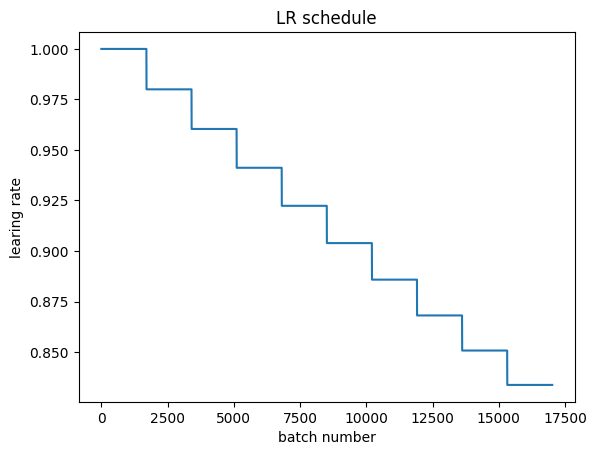

In [12]:
def schedule(step_number):
    n_epoch = step_number // (len(train)/batch_size)
    return 0.98**n_epoch
    

n_steps = round((len(train)/batch_size)*10)
plt.plot(np.arange(n_steps), [schedule(step) for step in np.arange(n_steps)])
plt.title('LR schedule')
plt.ylabel('learing rate')
plt.xlabel('batch number');

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from datasets import load_metric
f1 = load_metric('f1')

In [15]:
from shutil import copyfile

copyfile(src = "/kaggle/input/mymobilenetv2/mobilenetv2.py", dst = "../working/mobilenetv2.py")

'../working/mobilenetv2.py'

In [16]:
from mobilenetv2 import MobileNetV2

In [17]:
n_classes = n_colors

# MobileNetV2 with Adam

In [18]:
model_configuration = [
            (1,16,1,1),
            (6,24,2,2),
            (6,32,3,2),
            (6,64,4,2),
            (6,96,3,1),
            (6,160,3,2),
            (6,320,1,1)
        ]
model = MobileNetV2(model_configuration=model_configuration, in_channels=3, n_classes=n_classes, width_multiplier=1)
model.to(DEVICE)

for i, param in enumerate(model.parameters()):
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
loss_func = nn.CrossEntropyLoss()

all_adam_val_losses = []
all_adam_val_f1 = []

n_epochs = 10

from datetime import datetime
start = datetime.now()
model.eval()
predictions = []
answers = []
losses = []
for _, batch_val in enumerate(val_sequence_dataloader):

    x_val = batch_val['pixel_values'].to(DEVICE)
    y_val = batch_val['label'].to(DEVICE)

    with torch.no_grad():
        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        losses.append(val_loss.cpu())
        predictions.extend(torch.argmax(val_preds, dim=1))
        answers.extend(y_val)

val_f1 = f1.compute(predictions=predictions, references=answers,  average='macro')['f1']
mean_val_loss = np.mean(losses)
all_adam_val_losses.append(mean_val_loss)
all_adam_val_f1.append(val_f1)
print(f"epoch: -1, actual_lr: {optimizer.param_groups[0]['lr']}, val_loss: {mean_val_loss}, f1: {val_f1}")


for i in range(n_epochs):
    
    model.train()
    for _, batch in enumerate(train_sequence_dataloader):
        x_train = batch['pixel_values'].to(DEVICE)
        y_train = batch['label'].to(DEVICE)
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()
    
    
    model.eval()
    predictions = []
    answers = []
    losses = []
    
    for _, batch_val in enumerate(val_sequence_dataloader):

        x_val = batch_val['pixel_values'].to(DEVICE)
        y_val = batch_val['label'].to(DEVICE)

        with torch.no_grad():
            val_preds = model(x_val)
            val_loss = loss_func(val_preds, y_val)
            losses.append(val_loss.cpu())
            predictions.extend(torch.argmax(val_preds, dim=1))
            answers.extend(y_val)

    val_f1 = f1.compute(predictions=predictions, references=answers,  average='macro')['f1']
    mean_val_loss = np.mean(losses)
    all_adam_val_losses.append(mean_val_loss)
    all_adam_val_f1.append(val_f1)
    print(f"epoch: {i}, actual_lr: {optimizer.param_groups[0]['lr']}, val_loss: {mean_val_loss}, f1: {val_f1}")
    
print(datetime.now() - start)

epoch: -1, actual_lr: 0.005, val_loss: 2.398015022277832, f1: 0.015151515151515154
epoch: 0, actual_lr: 0.0049, val_loss: 1.1830412149429321, f1: 0.5575182860343202
epoch: 1, actual_lr: 0.004802, val_loss: 1.034462809562683, f1: 0.6361034676321158
epoch: 2, actual_lr: 0.0047059599999999995, val_loss: 1.0396865606307983, f1: 0.6235978023771535
epoch: 3, actual_lr: 0.004611840799999999, val_loss: 0.8240255117416382, f1: 0.7025469010986053
epoch: 4, actual_lr: 0.004519603984, val_loss: 0.9300814867019653, f1: 0.6894792611466805
epoch: 5, actual_lr: 0.00442921190432, val_loss: 0.7366396188735962, f1: 0.746562034262044
epoch: 6, actual_lr: 0.0043406276662336, val_loss: 0.6797474026679993, f1: 0.77483432442315
epoch: 7, actual_lr: 0.004253815112908927, val_loss: 0.6862393021583557, f1: 0.7701268396630838
epoch: 8, actual_lr: 0.004168738810650749, val_loss: 0.6602475047111511, f1: 0.7759079261949804
epoch: 9, actual_lr: 0.004085364034437733, val_loss: 0.6807250380516052, f1: 0.778916018395376

In [19]:
torch.save(model.state_dict(), 'mobilenetv2_adam_10epochs.pth')

# MobileNetV2 with Adamax

In [20]:
model_configuration = [
            (1,16,1,1),
            (6,24,2,2),
            (6,32,3,2),
            (6,64,4,2),
            (6,96,3,1),
            (6,160,3,2),
            (6,320,1,1)
        ]
model = MobileNetV2(model_configuration=model_configuration, in_channels=3, n_classes=n_classes, width_multiplier=1)
model.to(DEVICE)

for i, param in enumerate(model.parameters()):
    param.requires_grad = True


optimizer = torch.optim.Adamax(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
loss_func = nn.CrossEntropyLoss()

all_adamax_val_losses = []
all_adamax_val_f1 = []

n_epochs = 10

from datetime import datetime
start = datetime.now()
model.eval()
predictions = []
answers = []
losses = []
for _, batch_val in enumerate(val_sequence_dataloader):

    x_val = batch_val['pixel_values'].to(DEVICE)
    y_val = batch_val['label'].to(DEVICE)

    with torch.no_grad():
        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        losses.append(val_loss.cpu())
        predictions.extend(torch.argmax(val_preds, dim=1))
        answers.extend(y_val)

val_f1 = f1.compute(predictions=predictions, references=answers,  average='macro')['f1']
mean_val_loss = np.mean(losses)
all_adamax_val_losses.append(mean_val_loss)
all_adamax_val_f1.append(val_f1)
print(f"epoch: -1, actual_lr: {optimizer.param_groups[0]['lr']}, val_loss: {mean_val_loss}, f1: {val_f1}")


for i in range(n_epochs):
    
    model.train()
    for _, batch in enumerate(train_sequence_dataloader):
        x_train = batch['pixel_values'].to(DEVICE)
        y_train = batch['label'].to(DEVICE)
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()
    
    
    model.eval()
    predictions = []
    answers = []
    losses = []
    
    for _, batch_val in enumerate(val_sequence_dataloader):

        x_val = batch_val['pixel_values'].to(DEVICE)
        y_val = batch_val['label'].to(DEVICE)

        with torch.no_grad():
            val_preds = model(x_val)
            val_loss = loss_func(val_preds, y_val)
            losses.append(val_loss.cpu())
            predictions.extend(torch.argmax(val_preds, dim=1))
            answers.extend(y_val)

    val_f1 = f1.compute(predictions=predictions, references=answers,  average='macro')['f1']
    mean_val_loss = np.mean(losses)
    all_adamax_val_losses.append(mean_val_loss)
    all_adamax_val_f1.append(val_f1)
    print(f"epoch: {i}, actual_lr: {optimizer.param_groups[0]['lr']}, val_loss: {mean_val_loss}, f1: {val_f1}")
    
    
print(datetime.now() - start)

epoch: -1, actual_lr: 0.005, val_loss: 2.39808988571167, f1: 0.015151515151515154
epoch: 0, actual_lr: 0.0049, val_loss: 1.112119436264038, f1: 0.6143688731518155
epoch: 1, actual_lr: 0.004802, val_loss: 0.8904568552970886, f1: 0.6976966685537103
epoch: 2, actual_lr: 0.0047059599999999995, val_loss: 0.8444069027900696, f1: 0.7059940949799511
epoch: 3, actual_lr: 0.004611840799999999, val_loss: 0.7376531362533569, f1: 0.7550952940955183
epoch: 4, actual_lr: 0.004519603984, val_loss: 0.7034805417060852, f1: 0.7649465457236794
epoch: 5, actual_lr: 0.00442921190432, val_loss: 0.7371708154678345, f1: 0.762235888066312
epoch: 6, actual_lr: 0.0043406276662336, val_loss: 0.6691616773605347, f1: 0.7758259429108747
epoch: 7, actual_lr: 0.004253815112908927, val_loss: 0.6856997013092041, f1: 0.77388538928686
epoch: 8, actual_lr: 0.004168738810650749, val_loss: 0.6519482731819153, f1: 0.7865702853783378
epoch: 9, actual_lr: 0.004085364034437733, val_loss: 0.6128212213516235, f1: 0.803274524241457


In [21]:
torch.save(model.state_dict(), 'mobilenetv2_adamax_10epochs.pth')

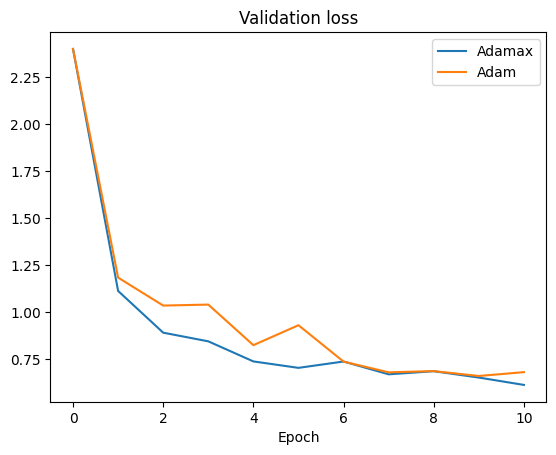

In [22]:
import matplotlib.pyplot as plt

# Sample data
x = range(0, 11)

# Plotting the lines
plt.plot(x, all_adamax_val_losses, label='Adamax')
plt.plot(x, all_adam_val_losses, label='Adam')

# Adding a legend
plt.legend()

# Adding labels and title
plt.xlabel('Epoch')
plt.title('Validation loss')

# Displaying the plot
plt.show()

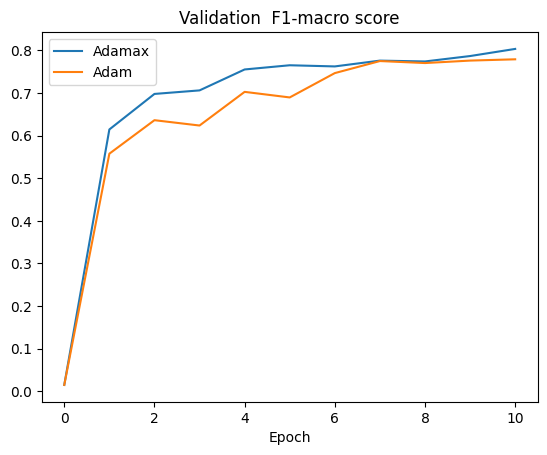

In [23]:
import matplotlib.pyplot as plt

# Sample data
x = range(0, 11)

# Plotting the lines
plt.plot(x, all_adamax_val_f1, label='Adamax')
plt.plot(x, all_adam_val_f1, label='Adam')

# Adding a legend
plt.legend()

# Adding labels and title
plt.xlabel('Epoch')
plt.title('Validation  F1-macro score')

# Displaying the plot
plt.show()